In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import pickle
pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 1000)  # or 1000
import time
from numpy import concatenate
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

In [10]:
# Make sure you are in the main folder('..\Erken_Algal_Bloom_Machine_Learning_Model')
cd = os.getcwd()
while cd.split('\\')[-1]!='Erken_Algal_Bloom_Machine_Learning_Model':
    os.chdir('..')
    cd=os.getcwd()
Observation=cd+'\\Training data'
LSTM_save_folder=cd+'\\Work record\\4-2019-2020 test\\LSTM'
GBR_save_folder=cd+'\\Work record\\4-2019-2020 test\\GBR'

In [11]:
# Load training dataset
os.chdir(Observation)
lakename='Erken'
all_df = pd.read_csv(lakename+'_Observation_df_nowinter.csv',sep = '\t',parse_dates=['Date'])

In [12]:
training_yr_df={}
test_time = [pd.Timestamp(2019,1,1),pd.Timestamp(2020,12,31)]
test_yr=list(range(test_time[0].year,test_time[1].year+1))
# 14 daily physical factors
n_feature = 14
# Create the daily df with Nan in nutrients columns
n_Nut = 7
Nut_f = ['Date', 'NOX', 'O2', 'PO4', 'TotP', 'NH4', 'Si', 'Chl']
Lake_Nut_metrics = pd.DataFrame(columns = Nut_f[1:],index=['MAE','RMSE','R2'])
Nut_df=all_df[Nut_f]
# set the hyperparameters
hyperparameters = {'n_batch':20,'nb_epoch':100,'n_neuros':100,'dropout':0.05,'time_steps':7,
                   'n_out':1,'verbose':0,'loss_function':'mae'}

# LSTM

In [13]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, var_name,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] # number of variables
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(var_name[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(var_name[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(var_name[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

# Load testing dataset(Daily data)
def read_daily_df(features,file):
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[features]
    return Lake_HydMet

# reframe dataset
def reframe(values,hyperparameters,var_names):
    reframed = series_to_supervised(values, hyperparameters['time_steps'], hyperparameters['n_out'],var_names)
    reframed = reframed.iloc[hyperparameters['time_steps']:]
    drop_col =[]
    n_var = len(var_names)
    for i in range(1,hyperparameters['time_steps']+1):
        drop_col += [n_var*i-1]
    reframed.drop(reframed.iloc[:,drop_col],axis=1,inplace = True)
    return reframed

# load dataset
def load_dataset(df,var_name):
    values = df[var_name].values
    return values

def sparse_dataset(data_X,data_y):
    index = []
    y = []
    for i in range(len(data_y)):
        if ~np.isnan(data_y[i]):
            index.append(i)
            y.append(data_y[i])
    X = np.stack(data_X[index,:,:])
    y = np.array(y)
    return index,X,y

def fit_lstm(train_X,train_y,n_batch,nb_epoch,n_neuros,dropout,verbose,loss_function):
    # design network
    model = Sequential()
    model.add(LSTM(n_neuros,  return_sequences = True,
              input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros, return_sequences = True))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss=loss_function, optimizer='adam')
    # fit network
    model.fit(train_X,train_y,epochs =nb_epoch,batch_size = n_batch,verbose = verbose)
    return model

def split_dataset(train,test,time_steps):
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], time_steps+1, int(train_X.shape[1]/(time_steps+1))))
    test_X = test_X.reshape((test_X.shape[0], time_steps+1, int(test_X.shape[1]/(time_steps+1))))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    print('number of input timesteps: {}'.format(train_X.shape[1]))
    print('number of features: {}'.format(train_X.shape[2]))
    return train_X, train_y,test_X, test_y

def plot_comparison(df,y,yhat,yhat_ts,n_date,time_steps,index,rmse,mae,r2,nutrient,test_time,ylim):
    # Observation time
    time = df['Date'].iloc[n_date+time_steps:].reset_index()['Date'].iloc[index] 
    # Direct comparison of observation and prediction [yhat] (data point to data point)
    pred = pd.DataFrame(concatenate((yhat.reshape(yhat.shape[0],1),y.reshape(y.shape[0],1)), axis=1),
                        index = time)
    pred.columns = ['Prediction','True value']
    # Extract the continuous timeseries from input dataset
    time_ts = df['Date'].iloc[n_date+time_steps:]
    # The continuous prediction yhat_ts 
    pred_ts = pd.DataFrame(yhat_ts,index = time_ts,columns = ['Prediction'])
    # Compute the 7d rolling mean of the timeseries predction
    pred_ts['Prediction_7d'] = pred_ts['Prediction'].rolling(7,min_periods = 1).mean()
    # Create a continous timeseries without winter gap
    Date = pd.DataFrame(pd.date_range(start = time_ts.iloc[0],
                                  end = time_ts.iloc[-1]),
                    columns = ['Date'])
    pred_ts_gap = Date.merge(pred_ts,how = 'left',on = 'Date')
    f1,ax1 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    pred_ts_gap.plot(x = 'Date',y = ['Prediction','Prediction_7d'],
                     style = {'Prediction':'b-','Prediction_7d':'k-'},
                     ax = ax1[0])
    pred.plot(y = 'True value',style='ro',alpha = 0.7,ms = 7,ax = ax1[0])
    ax1[0].set_ylabel(nutrient)
    ax1[0].set_xlim((test_time[0],test_time[1]))
    ax1[0].set_ylim(ylim)
    ax1[0].text(0.7, 0.9, 'RMSE:{}, MAE:{}'.format(round(rmse,2),round(mae,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax1[0].transAxes,fontsize='x-large')
    ax1[0].legend(frameon=False)
    pred.plot(x = 'True value', y = 'Prediction',kind = 'scatter',s = 20,c = 'blue',ax = ax1[1])
    ax1[1].plot(pred['True value'],pred['True value'],lw  =1.5,color = 'black')
    ax1[1].text(0.5, 0.8, 'R2:{}'.format(round(r2,2)), 
                horizontalalignment='center',verticalalignment='center', 
                transform=ax1[1].transAxes,fontsize='x-large')
    return f1,pred_ts

# ensure all data is float
def predict_lstm(df,values,var_name,nutrient,test_time,hyperparameters,ylim):
    n_date = df[(df['Date']<test_time[0])|(df['Date']>test_time[1])]['Date'].count() # number of dates used for trainning
    if df[(df['Date']<test_time[0])].empty:
        train = values[-n_date-1:-1, :] # Testing years are in front of training years: train = values[-n_date-1:-1, :]
        test = values[:-n_date, :] # Testing years are in front of training years: test = values[:-n_date, :]
    if df[(df['Date']>test_time[1])].empty:
        train = values[:n_date, :] # Testing years are after training years: train = values[:n_date, :]
        test = values[n_date:, :] # Testing years are after training years: test = values[n_date:, :]

    # Testing years 
    train_X, train_y,test_X, test_y = split_dataset(train,test,hyperparameters['time_steps'])
    train_y=Scaler_y.fit_transform(train_y.reshape(-1, 1))
    # fit the lstm model
    index,X,y = sparse_dataset(train_X,train_y) # stack the timeseries input together to create a 2D training input X, and a 1D lable y
    #y_scaled = Scaler.fit_transform(y.reshape(-1,1))
    print('number of samples: {}'.format(len(index)))
    kf = KFold(n_splits=5, shuffle=True, random_state=101) # 5-fold cross validation
    RMSE = []
    MAE = []
    R2 = []
    # fit the lstm model 
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = fit_lstm(X_train,y_train,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                         hyperparameters['n_neuros'],hyperparameters['dropout'],
                         hyperparameters['verbose'],hyperparameters['loss_function'])
        yhat = Scaler_y.inverse_transform(model.predict(X_test,batch_size = hyperparameters['n_batch']))
        y_test = Scaler_y.inverse_transform(y_test.reshape(-1, 1))
        rmse = mean_squared_error(y_test, yhat,squared=False)
        mae= mean_absolute_error(y_test, yhat)
        r2 =  r2_score(y_test, yhat)
        RMSE.append(rmse) 
        MAE.append(mae)
        R2.append(r2)
        #print('Training RMSE: %.2f' %rmse)       
    # make a prediction
    model = fit_lstm(X,y,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                     hyperparameters['n_neuros'],hyperparameters['dropout'],
                     hyperparameters['verbose'],hyperparameters['loss_function'])
    index,X,y = sparse_dataset(test_X,test_y.reshape(-1, 1)) # index is the time series
    yhat = Scaler_y.inverse_transform(model.predict(X,batch_size = hyperparameters['n_batch']))
    rmse = mean_squared_error(y, yhat,squared=False)
    mae = mean_absolute_error(y,yhat)
    r2 = r2_score(y, yhat)
    print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
    print("Training dataset MAE %.2f (+/- %.2f)" % (np.mean(MAE), np.std(MAE)))
    print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
    # make a prediction for the whole timeseries
    yhat_ts = Scaler_y.inverse_transform(model.predict(test_X,batch_size = hyperparameters['n_batch']))
    figure,pred_ts = plot_comparison(df,y,yhat,yhat_ts,n_date,hyperparameters['time_steps'],index,rmse,mae,r2,nutrient,test_time,ylim)
    return model,rmse,mae,r2,figure,pred_ts

def compare(Erken_Nut,Nut_memory,nutrient,Lake_Nut_metrics,hat):
    compare = Erken_Nut.merge(Nut_memory,on = 'Date',how = 'left')[['Date',nutrient+'_x',nutrient+'_y']].dropna()
    compare.columns = [['Date','ML','OB']]
    Lake_Nut_metrics[nutrient].MAE= mean_absolute_error(compare['OB'], compare['ML'])
    Lake_Nut_metrics[nutrient].RMSE = mean_squared_error(compare['OB'], compare['ML'],squared=False)
    Lake_Nut_metrics[nutrient].R2 = r2_score(compare['OB'], compare['ML'])
    # Add the time-series prediction into sample dataset for next variable modeling
    Nut_memory.loc[Nut_memory['year'].isin(test_yr),nutrient] = hat
    return Lake_Nut_metrics,Nut_memory

def predict_ts(df,nutrient,model,hyperparameters,values):
    # add the predictive values into dataset
    value_X, value_y = values[:, :-1], values[:, -1]
    value_X = value_X.reshape((value_X.shape[0], hyperparameters['time_steps']+1, int(value_X.shape[1]/(hyperparameters['time_steps']+1))))
    y_pred = Scaler_y.inverse_transform(model.predict(value_X,batch_size = hyperparameters['n_batch']))    
    df[nutrient].iloc[hyperparameters['time_steps']:]=y_pred[:,0]
    df[nutrient].fillna(method = 'backfill',inplace = True)
    return df

# Load testing dataset(Daily data)
def read_daily_df(features,file):
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[features]
    return Lake_HydMet

def resample(Nut,Erken_Met,sample_interval,test_yr):
    # Resample the dataset
    drop_row = []
    dT = 0
    i = 1
    Nut_sample = Nut.copy()
    Nut_sample['year'] = Nut_sample['Date'].apply(lambda yr:yr.year)
    Nut_train = Nut_sample[~Nut_sample['year'].isin(test_yr)]
    Nut_test = Nut_sample[Nut_sample['year'].isin(test_yr)]
    while True:
        dT = (Nut_train['Date'].iloc[i]-Nut_train['Date'].iloc[i-1])/np.timedelta64(1, 'D')
        if dT<sample_interval: # set the data frequency (over 10, 14, 20 days)
            #print(sample_df['Date'].iloc[i])
            Nut_train.drop(Nut_train.index.values[i],axis = 0,inplace  =True)
        else:
            i+=1
        if i>=len(Nut_train):break
    Nut_sample = pd.concat([Nut_train,Nut_test]).sort_values(by= 'Date')
    #Nut_memory = Erken_Met.merge(Nut_sample,how = 'left',on = 'Date')
    #Nut_memory['year'] = Nut_memory['Date'].apply(lambda d:d.year)
    return Nut_sample

NOX
(4119, 8, 14) (4119,) (543, 8, 14) (543,)
number of input timesteps: 8
number of features: 14
number of samples: 486
Training dataset RMSE 3.00 (+/- 0.23)
Training dataset MAE 1.42 (+/- 0.14)
Training dataset R2 0.34 (+/- 0.20)
Test RMSE: 3.14
Test MAE: 1.26
Test R2: 0.32
Model takes 4 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


O2
(4119, 8, 15) (4119,) (543, 8, 15) (543,)
number of input timesteps: 8
number of features: 15
number of samples: 750
Training dataset RMSE 27.64 (+/- 2.19)
Training dataset MAE 18.35 (+/- 1.12)
Training dataset R2 0.77 (+/- 0.04)
Test RMSE: 24.48
Test MAE: 18.99
Test R2: 0.85
Model takes 7 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


PO4
(4119, 8, 16) (4119,) (543, 8, 16) (543,)
number of input timesteps: 8
number of features: 16
number of samples: 495
Training dataset RMSE 0.24 (+/- 0.02)
Training dataset MAE 0.15 (+/- 0.01)
Training dataset R2 0.69 (+/- 0.07)
Test RMSE: 0.17
Test MAE: 0.12
Test R2: 0.80
Model takes 6 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


TotP
(4119, 8, 17) (4119,) (543, 8, 17) (543,)
number of input timesteps: 8
number of features: 17
number of samples: 494
Training dataset RMSE 0.26 (+/- 0.02)
Training dataset MAE 0.19 (+/- 0.01)
Training dataset R2 0.61 (+/- 0.03)
Test RMSE: 0.26
Test MAE: 0.20
Test R2: 0.57
Model takes 7 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


NH4
(4119, 8, 18) (4119,) (543, 8, 18) (543,)
number of input timesteps: 8
number of features: 18
number of samples: 489
Training dataset RMSE 0.82 (+/- 0.20)
Training dataset MAE 0.52 (+/- 0.07)
Training dataset R2 0.20 (+/- 0.04)
Test RMSE: 0.75
Test MAE: 0.55
Test R2: -0.13
Model takes 7 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Si
(4119, 8, 19) (4119,) (543, 8, 19) (543,)
number of input timesteps: 8
number of features: 19
number of samples: 484
Training dataset RMSE 20.86 (+/- 1.45)
Training dataset MAE 16.20 (+/- 0.70)
Training dataset R2 0.06 (+/- 0.17)
Test RMSE: 23.31
Test MAE: 16.77
Test R2: -0.35
Model takes 6 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chl
(4119, 8, 20) (4119,) (543, 8, 20) (543,)
number of input timesteps: 8
number of features: 20
number of samples: 526
Training dataset RMSE 4.48 (+/- 0.42)
Training dataset MAE 2.73 (+/- 0.18)
Training dataset R2 0.40 (+/- 0.17)
Test RMSE: 6.68
Test MAE: 4.41
Test R2: 0.10
Model takes 6 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Model takes 6 min to run
NOX
(4119, 8, 14) (4119,) (543, 8, 14) (543,)
number of input timesteps: 8
number of features: 14
number of samples: 486
Training dataset RMSE 3.03 (+/- 0.53)
Training dataset MAE 1.44 (+/- 0.16)
Training dataset R2 0.30 (+/- 0.38)
Test RMSE: 2.97
Test MAE: 1.34
Test R2: 0.39
Model takes 6 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


O2
(4119, 8, 15) (4119,) (543, 8, 15) (543,)
number of input timesteps: 8
number of features: 15
number of samples: 750
Training dataset RMSE 26.49 (+/- 2.70)
Training dataset MAE 17.88 (+/- 1.45)
Training dataset R2 0.78 (+/- 0.04)
Test RMSE: 26.12
Test MAE: 20.21
Test R2: 0.83
Model takes 6 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


PO4
(4119, 8, 16) (4119,) (543, 8, 16) (543,)
number of input timesteps: 8
number of features: 16
number of samples: 495
Training dataset RMSE 0.24 (+/- 0.03)
Training dataset MAE 0.15 (+/- 0.02)
Training dataset R2 0.68 (+/- 0.08)
Test RMSE: 0.16
Test MAE: 0.12
Test R2: 0.81
Model takes 5 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


TotP
(4119, 8, 17) (4119,) (543, 8, 17) (543,)
number of input timesteps: 8
number of features: 17
number of samples: 494
Training dataset RMSE 0.26 (+/- 0.02)
Training dataset MAE 0.19 (+/- 0.01)
Training dataset R2 0.62 (+/- 0.05)
Test RMSE: 0.27
Test MAE: 0.20
Test R2: 0.55
Model takes 5 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


NH4
(4119, 8, 18) (4119,) (543, 8, 18) (543,)
number of input timesteps: 8
number of features: 18
number of samples: 489
Training dataset RMSE 0.83 (+/- 0.20)
Training dataset MAE 0.52 (+/- 0.07)
Training dataset R2 0.19 (+/- 0.03)
Test RMSE: 0.74
Test MAE: 0.57
Test R2: -0.11
Model takes 5 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Si
(4119, 8, 19) (4119,) (543, 8, 19) (543,)
number of input timesteps: 8
number of features: 19
number of samples: 484
Training dataset RMSE 20.41 (+/- 1.22)
Training dataset MAE 16.26 (+/- 1.15)
Training dataset R2 0.10 (+/- 0.15)
Test RMSE: 22.53
Test MAE: 16.79
Test R2: -0.26
Model takes 7 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chl
(4119, 8, 20) (4119,) (543, 8, 20) (543,)
number of input timesteps: 8
number of features: 20
number of samples: 526
Training dataset RMSE 4.25 (+/- 0.46)
Training dataset MAE 2.50 (+/- 0.24)
Training dataset R2 0.48 (+/- 0.10)
Test RMSE: 7.19
Test MAE: 4.63
Test R2: -0.05
Model takes 7 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Model takes 7 min to run
NOX
(4119, 8, 14) (4119,) (543, 8, 14) (543,)
number of input timesteps: 8
number of features: 14
number of samples: 486
Training dataset RMSE 3.04 (+/- 0.25)
Training dataset MAE 1.43 (+/- 0.15)
Training dataset R2 0.33 (+/- 0.20)
Test RMSE: 3.08
Test MAE: 1.38
Test R2: 0.34
Model takes 7 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


O2
(4119, 8, 15) (4119,) (543, 8, 15) (543,)
number of input timesteps: 8
number of features: 15
number of samples: 750
Training dataset RMSE 25.94 (+/- 3.03)
Training dataset MAE 17.67 (+/- 1.07)
Training dataset R2 0.79 (+/- 0.04)
Test RMSE: 26.26
Test MAE: 22.05
Test R2: 0.83
Model takes 8 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


PO4
(4119, 8, 16) (4119,) (543, 8, 16) (543,)
number of input timesteps: 8
number of features: 16
number of samples: 495
Training dataset RMSE 0.24 (+/- 0.02)
Training dataset MAE 0.16 (+/- 0.01)
Training dataset R2 0.67 (+/- 0.06)
Test RMSE: 0.19
Test MAE: 0.14
Test R2: 0.75
Model takes 7 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


TotP
(4119, 8, 17) (4119,) (543, 8, 17) (543,)
number of input timesteps: 8
number of features: 17
number of samples: 494
Training dataset RMSE 0.25 (+/- 0.02)
Training dataset MAE 0.19 (+/- 0.01)
Training dataset R2 0.63 (+/- 0.03)
Test RMSE: 0.29
Test MAE: 0.22
Test R2: 0.46
Model takes 5 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


NH4
(4119, 8, 18) (4119,) (543, 8, 18) (543,)
number of input timesteps: 8
number of features: 18
number of samples: 489
Training dataset RMSE 0.87 (+/- 0.17)
Training dataset MAE 0.54 (+/- 0.06)
Training dataset R2 0.08 (+/- 0.09)
Test RMSE: 0.79
Test MAE: 0.55
Test R2: -0.25
Model takes 5 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Si
(4119, 8, 19) (4119,) (543, 8, 19) (543,)
number of input timesteps: 8
number of features: 19
number of samples: 484
Training dataset RMSE 20.40 (+/- 1.37)
Training dataset MAE 15.82 (+/- 1.18)
Training dataset R2 0.10 (+/- 0.17)
Test RMSE: 28.67
Test MAE: 19.30
Test R2: -1.04
Model takes 5 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chl
(4119, 8, 20) (4119,) (543, 8, 20) (543,)
number of input timesteps: 8
number of features: 20
number of samples: 526
Training dataset RMSE 4.21 (+/- 0.42)
Training dataset MAE 2.60 (+/- 0.33)
Training dataset R2 0.47 (+/- 0.15)


C:\Users\shuli278\AppData\Local\Temp/ipykernel_19412/1292180964.py:101: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f1,ax1 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})


Test RMSE: 7.42
Test MAE: 4.96
Test R2: -0.11
Model takes 6 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Model takes 6 min to run
NOX
(4119, 8, 14) (4119,) (543, 8, 14) (543,)
number of input timesteps: 8
number of features: 14
number of samples: 486
Training dataset RMSE 2.80 (+/- 0.23)
Training dataset MAE 1.38 (+/- 0.11)
Training dataset R2 0.44 (+/- 0.13)
Test RMSE: 3.19
Test MAE: 1.49
Test R2: 0.30
Model takes 6 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


O2
(4119, 8, 15) (4119,) (543, 8, 15) (543,)
number of input timesteps: 8
number of features: 15
number of samples: 750
Training dataset RMSE 26.12 (+/- 3.35)
Training dataset MAE 17.40 (+/- 1.66)
Training dataset R2 0.79 (+/- 0.05)
Test RMSE: 28.88
Test MAE: 23.39
Test R2: 0.79
Model takes 8 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


PO4
(4119, 8, 16) (4119,) (543, 8, 16) (543,)
number of input timesteps: 8
number of features: 16
number of samples: 495
Training dataset RMSE 0.24 (+/- 0.02)
Training dataset MAE 0.15 (+/- 0.02)
Training dataset R2 0.67 (+/- 0.09)
Test RMSE: 0.16
Test MAE: 0.12
Test R2: 0.82
Model takes 6 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


TotP
(4119, 8, 17) (4119,) (543, 8, 17) (543,)
number of input timesteps: 8
number of features: 17
number of samples: 494
Training dataset RMSE 0.26 (+/- 0.02)
Training dataset MAE 0.19 (+/- 0.01)
Training dataset R2 0.62 (+/- 0.06)
Test RMSE: 0.28
Test MAE: 0.22
Test R2: 0.50
Model takes 6 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


NH4
(4119, 8, 18) (4119,) (543, 8, 18) (543,)
number of input timesteps: 8
number of features: 18
number of samples: 489
Training dataset RMSE 0.83 (+/- 0.19)
Training dataset MAE 0.52 (+/- 0.06)
Training dataset R2 0.17 (+/- 0.02)
Test RMSE: 0.70
Test MAE: 0.52
Test R2: 0.01
Model takes 6 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Si
(4119, 8, 19) (4119,) (543, 8, 19) (543,)
number of input timesteps: 8
number of features: 19
number of samples: 484
Training dataset RMSE 20.09 (+/- 1.60)
Training dataset MAE 15.82 (+/- 1.03)
Training dataset R2 0.13 (+/- 0.16)
Test RMSE: 21.64
Test MAE: 15.93
Test R2: -0.16
Model takes 7 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chl
(4119, 8, 20) (4119,) (543, 8, 20) (543,)
number of input timesteps: 8
number of features: 20
number of samples: 526
Training dataset RMSE 4.41 (+/- 0.52)
Training dataset MAE 2.58 (+/- 0.26)
Training dataset R2 0.44 (+/- 0.10)
Test RMSE: 6.84
Test MAE: 4.59
Test R2: 0.06
Model takes 7 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Model takes 8 min to run
NOX
(4119, 8, 14) (4119,) (543, 8, 14) (543,)
number of input timesteps: 8
number of features: 14
number of samples: 486
Training dataset RMSE 2.86 (+/- 0.09)
Training dataset MAE 1.40 (+/- 0.07)
Training dataset R2 0.42 (+/- 0.11)
Test RMSE: 3.18
Test MAE: 1.38
Test R2: 0.30
Model takes 6 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


O2
(4119, 8, 15) (4119,) (543, 8, 15) (543,)
number of input timesteps: 8
number of features: 15
number of samples: 750
Training dataset RMSE 27.36 (+/- 3.49)
Training dataset MAE 18.23 (+/- 1.94)
Training dataset R2 0.77 (+/- 0.05)
Test RMSE: 27.04
Test MAE: 20.98
Test R2: 0.82
Model takes 8 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


PO4
(4119, 8, 16) (4119,) (543, 8, 16) (543,)
number of input timesteps: 8
number of features: 16
number of samples: 495
Training dataset RMSE 0.23 (+/- 0.02)
Training dataset MAE 0.14 (+/- 0.01)
Training dataset R2 0.71 (+/- 0.07)
Test RMSE: 0.18
Test MAE: 0.13
Test R2: 0.77
Model takes 7 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


TotP
(4119, 8, 17) (4119,) (543, 8, 17) (543,)
number of input timesteps: 8
number of features: 17
number of samples: 494
Training dataset RMSE 0.25 (+/- 0.02)
Training dataset MAE 0.19 (+/- 0.01)
Training dataset R2 0.63 (+/- 0.02)
Test RMSE: 0.28
Test MAE: 0.21
Test R2: 0.51
Model takes 6 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


NH4
(4119, 8, 18) (4119,) (543, 8, 18) (543,)
number of input timesteps: 8
number of features: 18
number of samples: 489
Training dataset RMSE 0.84 (+/- 0.20)
Training dataset MAE 0.53 (+/- 0.07)
Training dataset R2 0.17 (+/- 0.03)
Test RMSE: 0.69
Test MAE: 0.51
Test R2: 0.04
Model takes 6 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Si
(4119, 8, 19) (4119,) (543, 8, 19) (543,)
number of input timesteps: 8
number of features: 19
number of samples: 484
Training dataset RMSE 20.22 (+/- 1.19)
Training dataset MAE 15.93 (+/- 0.72)
Training dataset R2 0.11 (+/- 0.16)
Test RMSE: 24.75
Test MAE: 17.14
Test R2: -0.52
Model takes 7 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chl
(4119, 8, 20) (4119,) (543, 8, 20) (543,)
number of input timesteps: 8
number of features: 20
number of samples: 526
Training dataset RMSE 4.45 (+/- 0.43)
Training dataset MAE 2.66 (+/- 0.19)
Training dataset R2 0.43 (+/- 0.10)
Test RMSE: 7.06
Test MAE: 4.56
Test R2: -0.01
Model takes 7 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Model takes 7 min to run


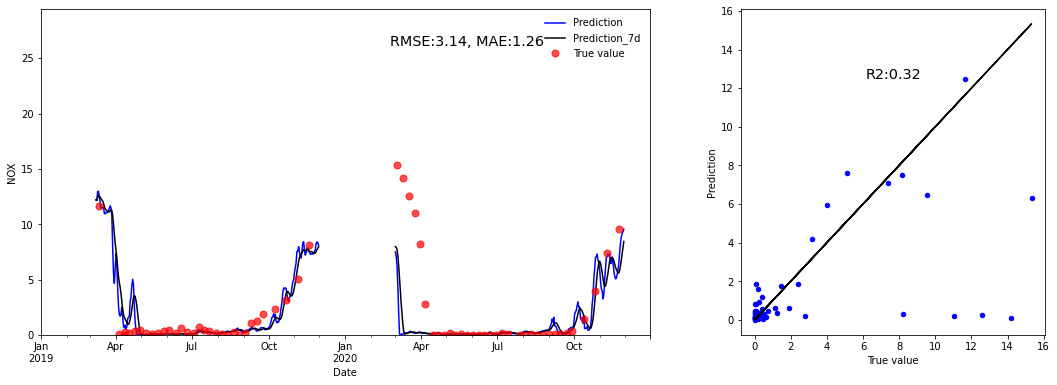

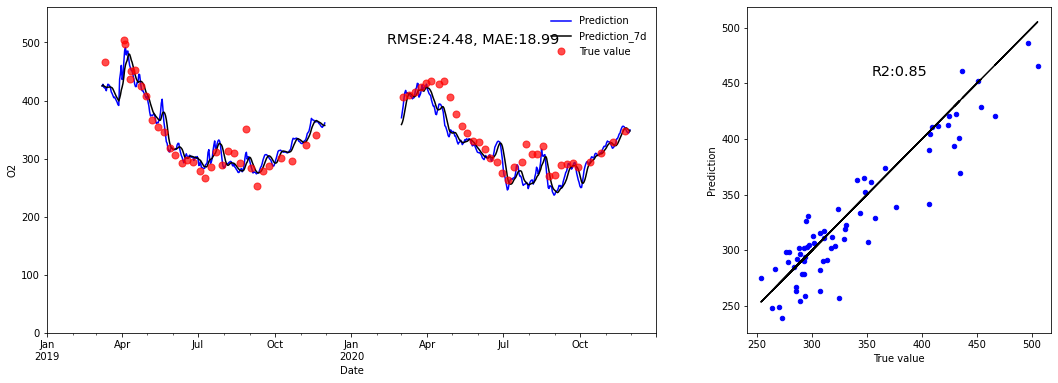

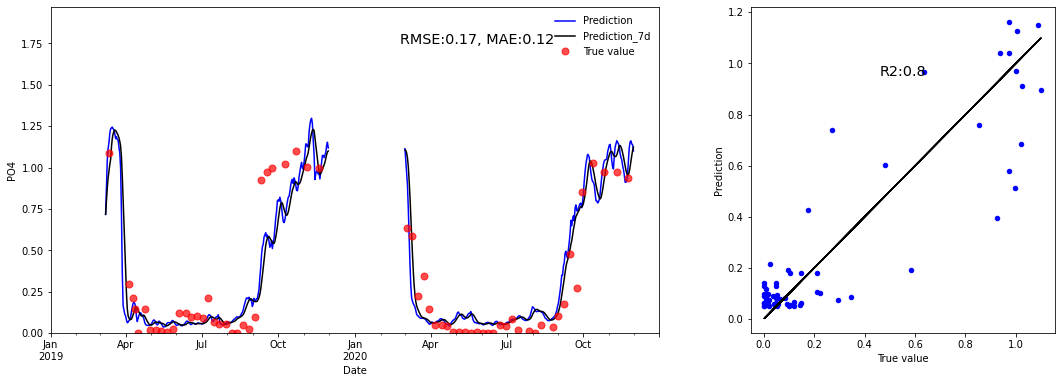

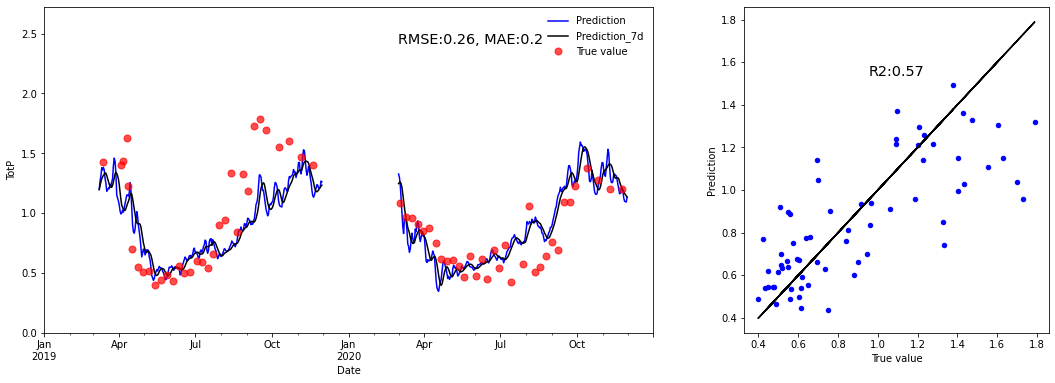

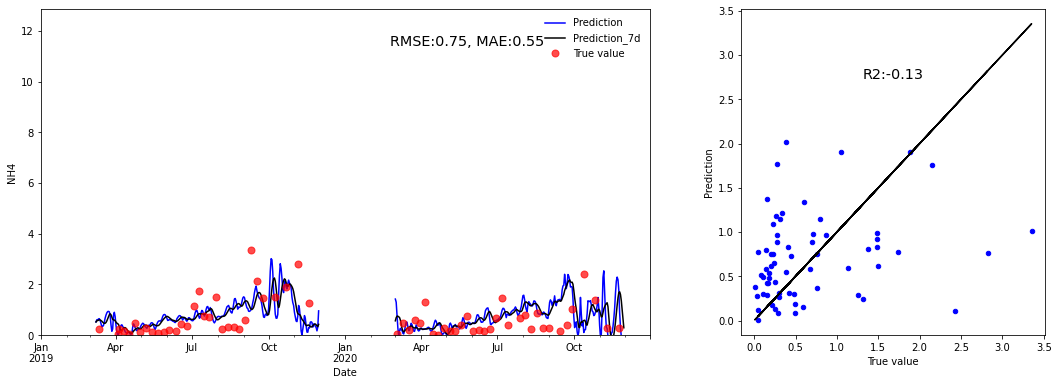

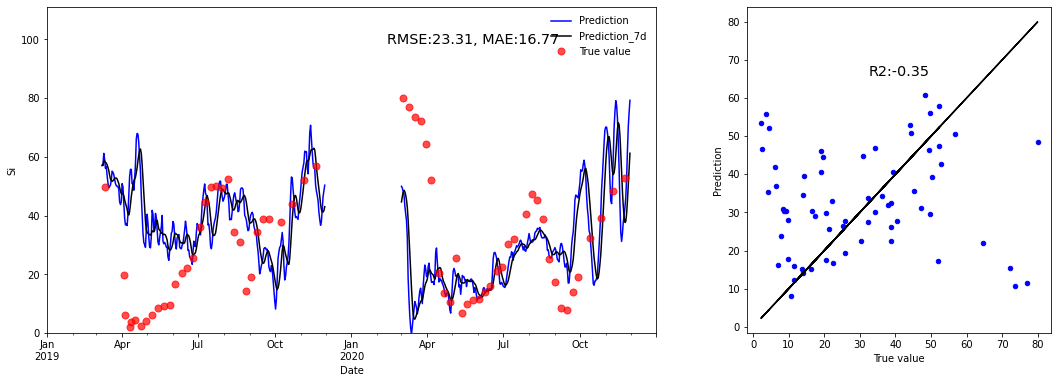

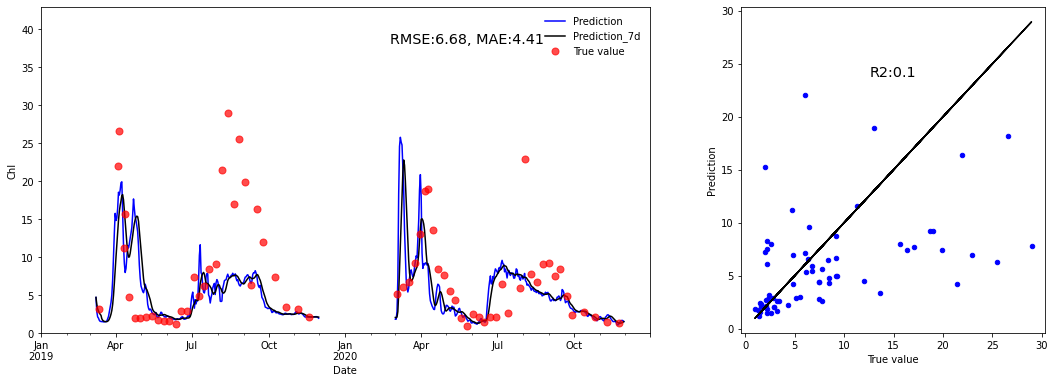

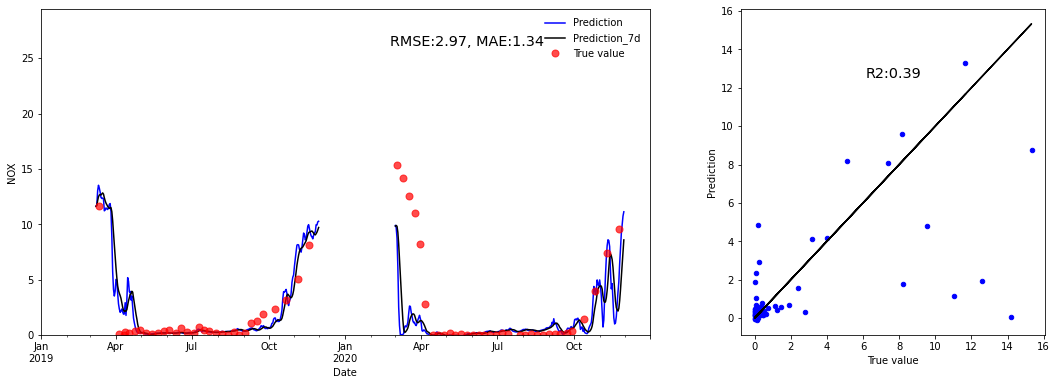

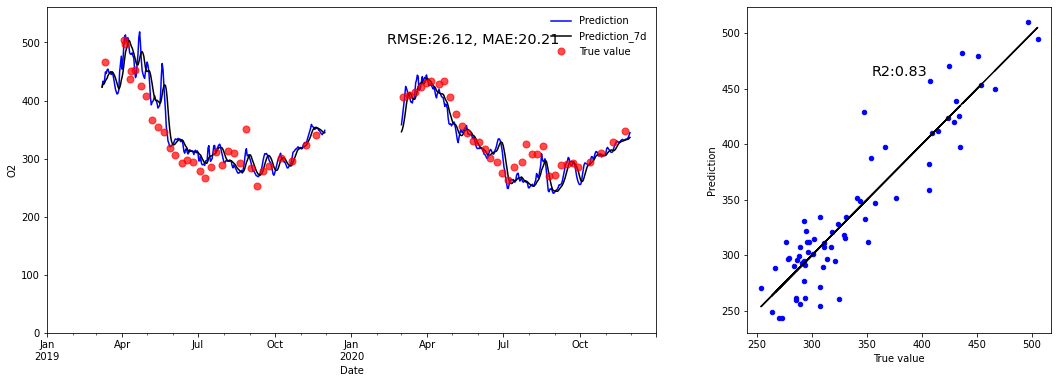

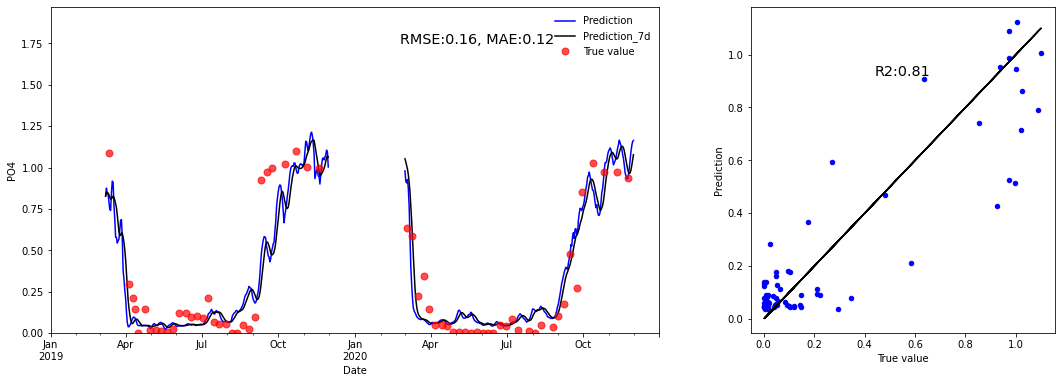

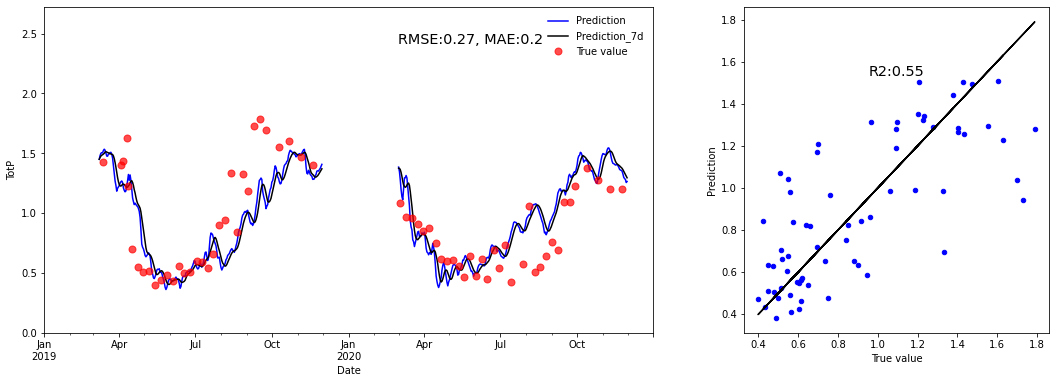

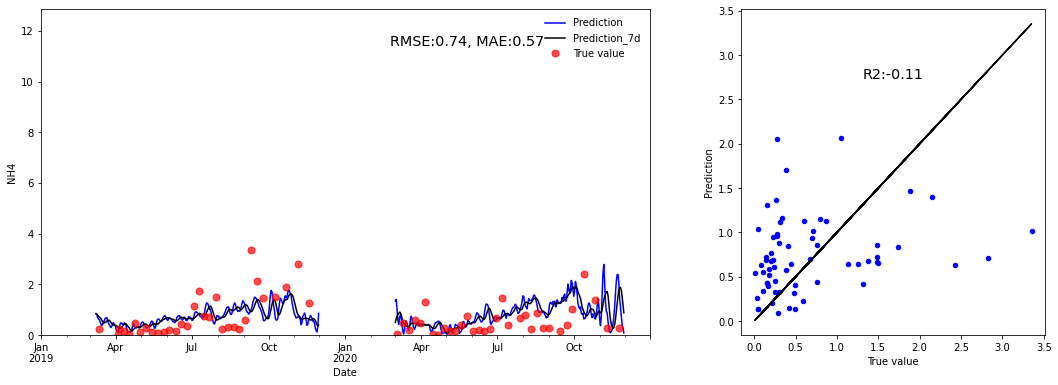

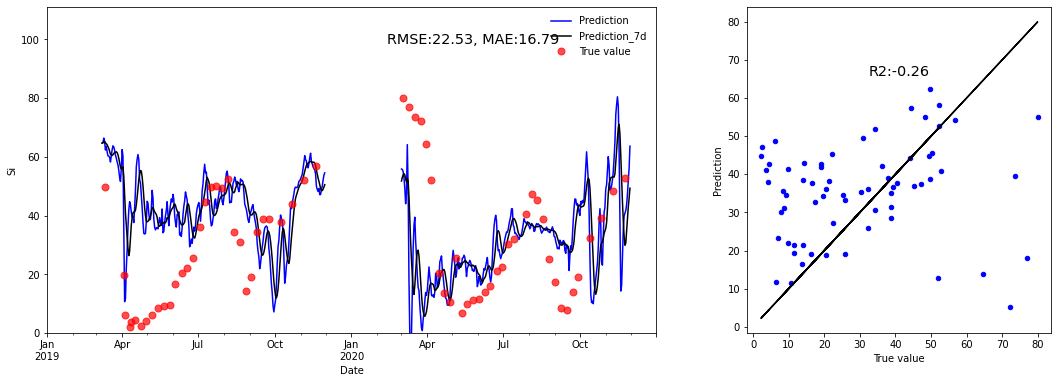

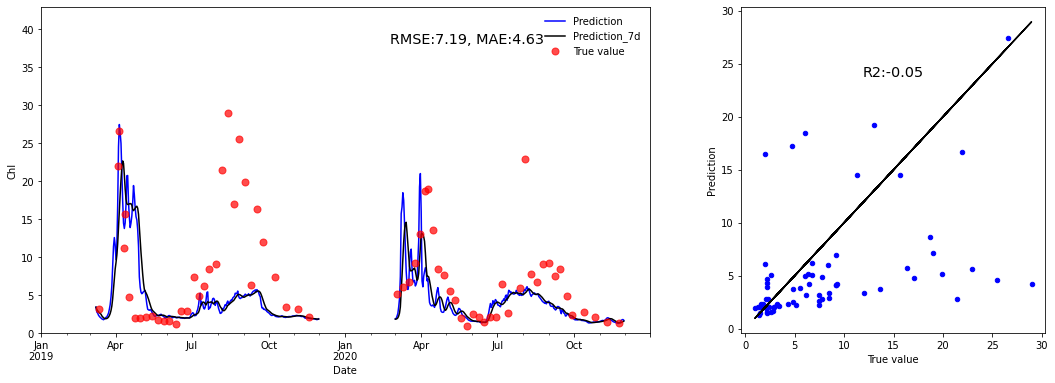

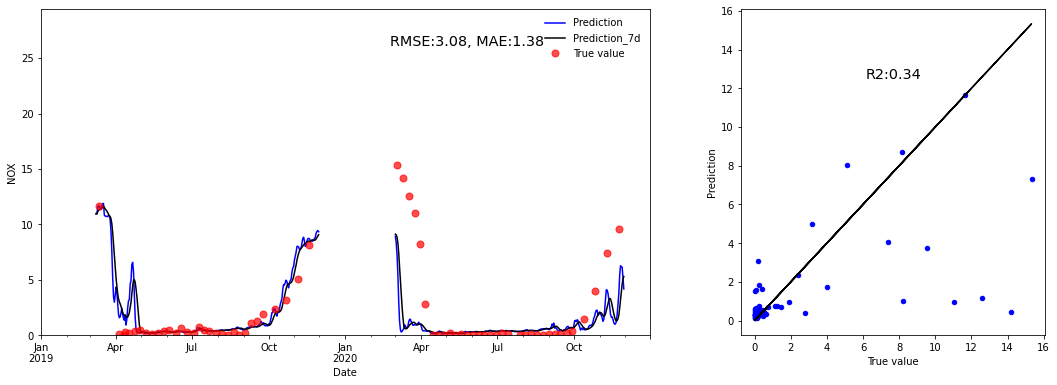

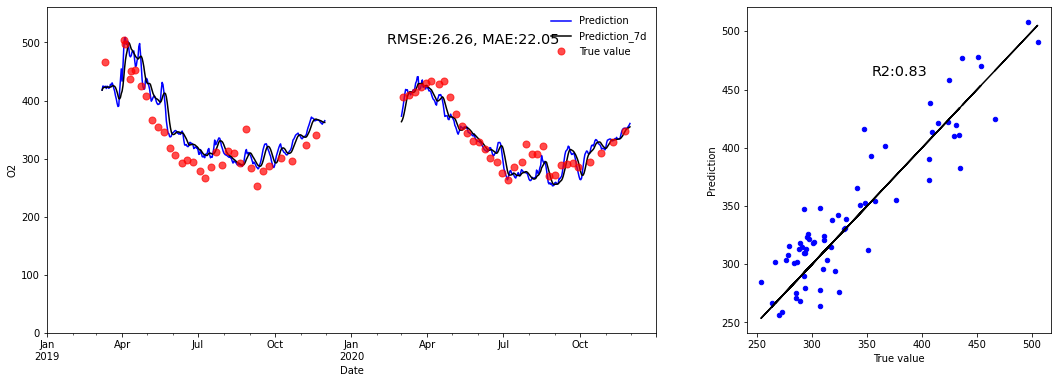

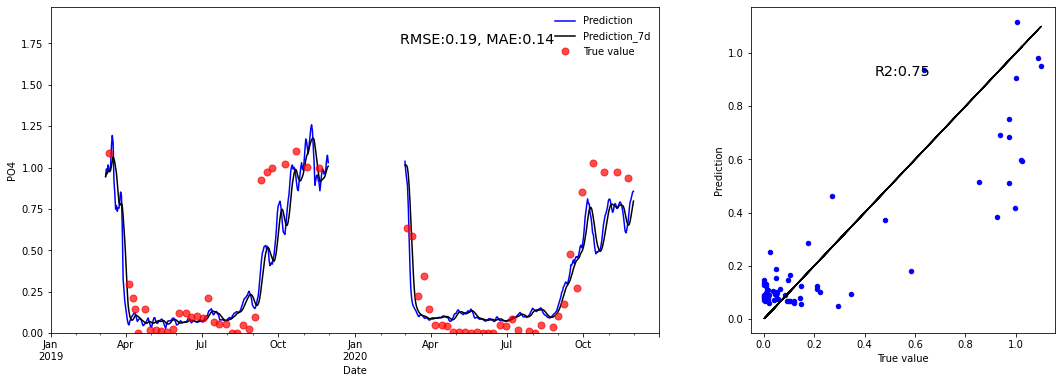

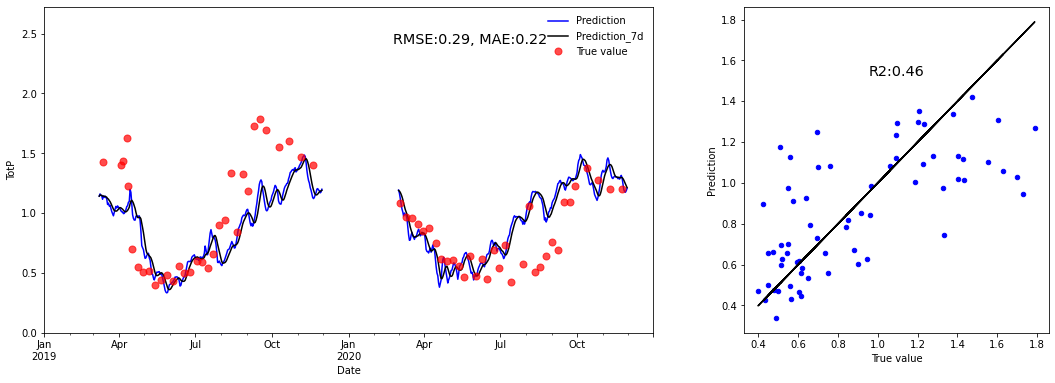

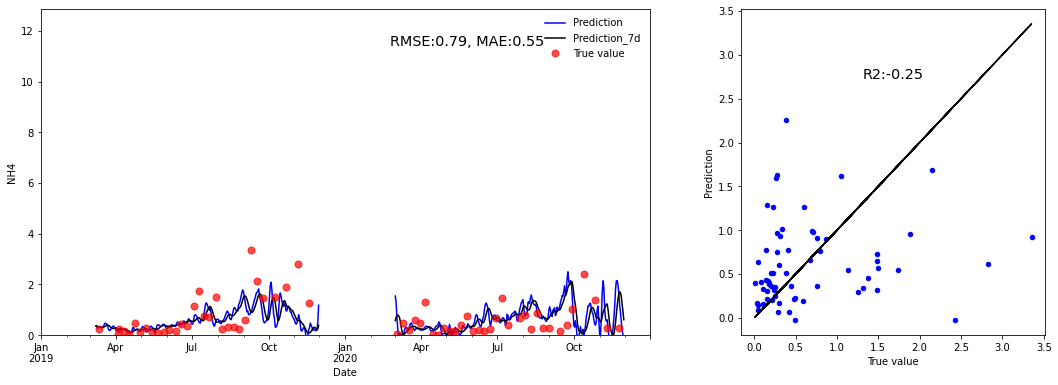

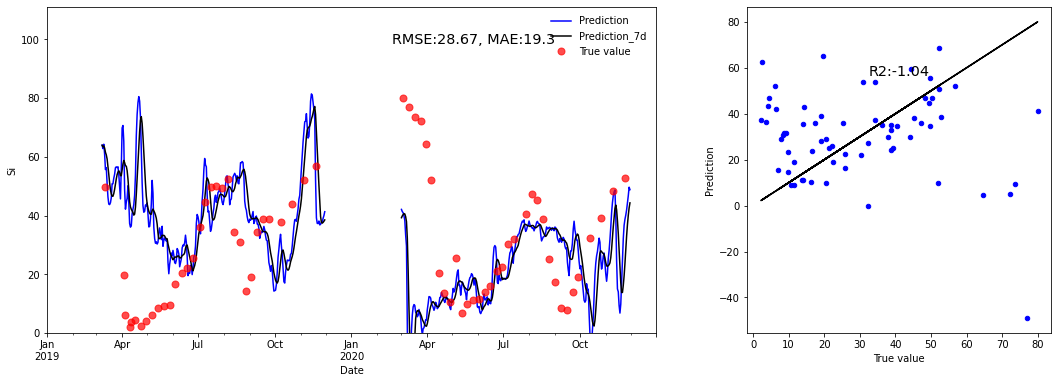

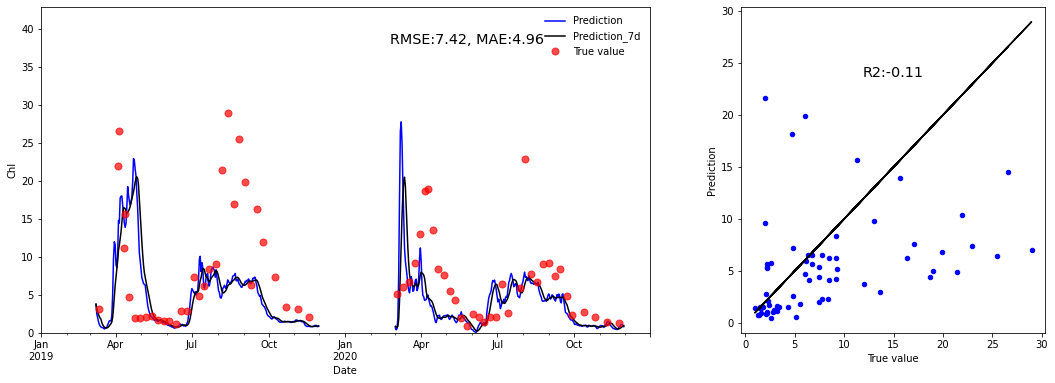

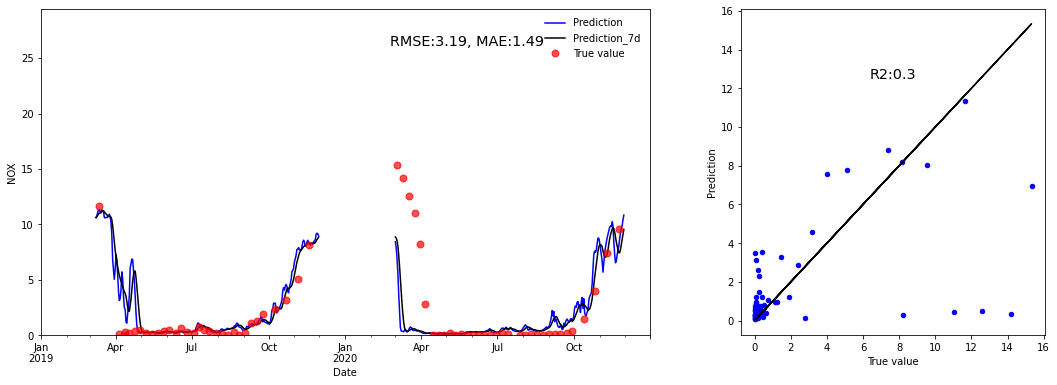

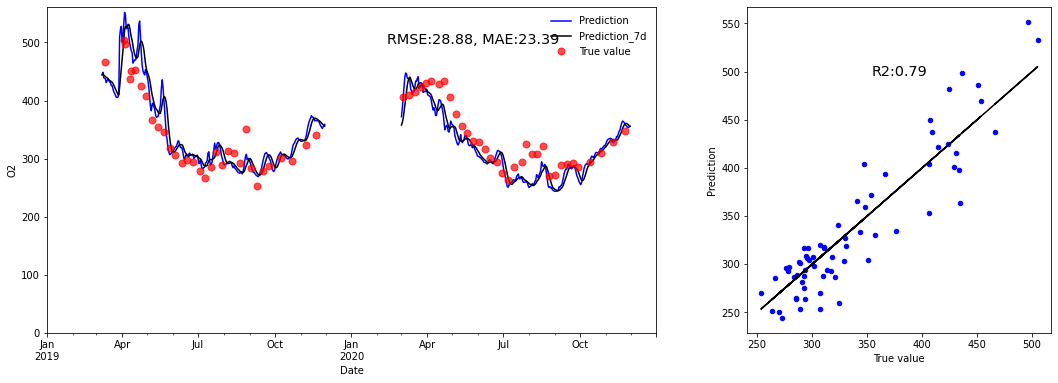

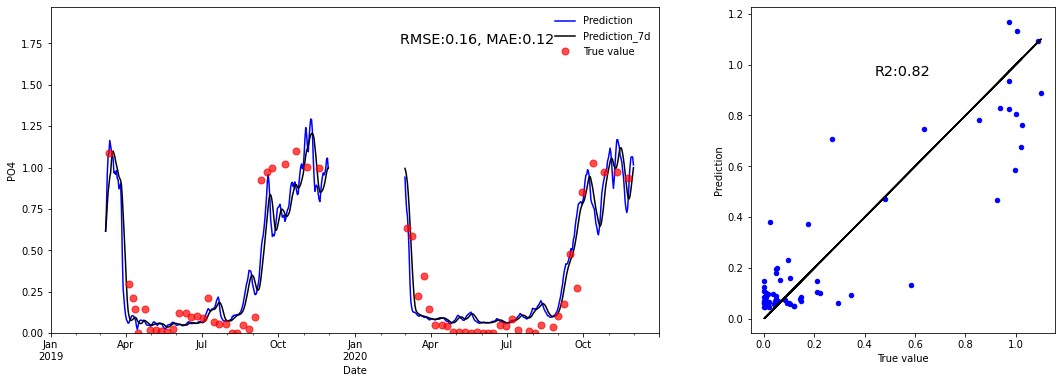

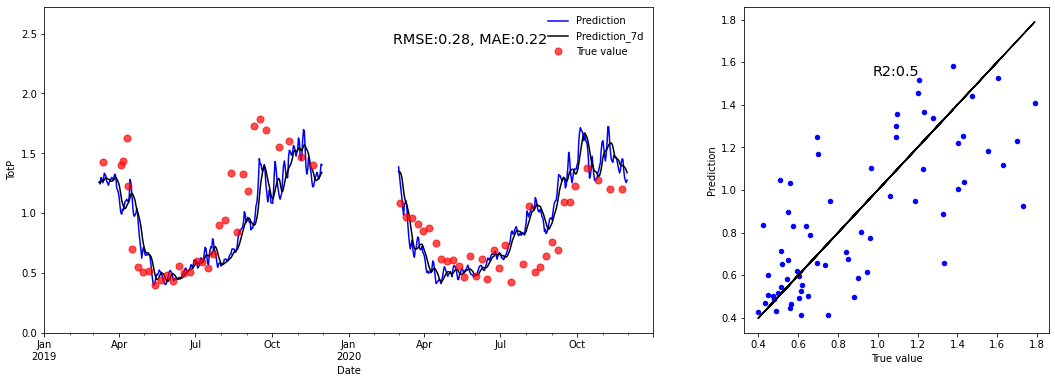

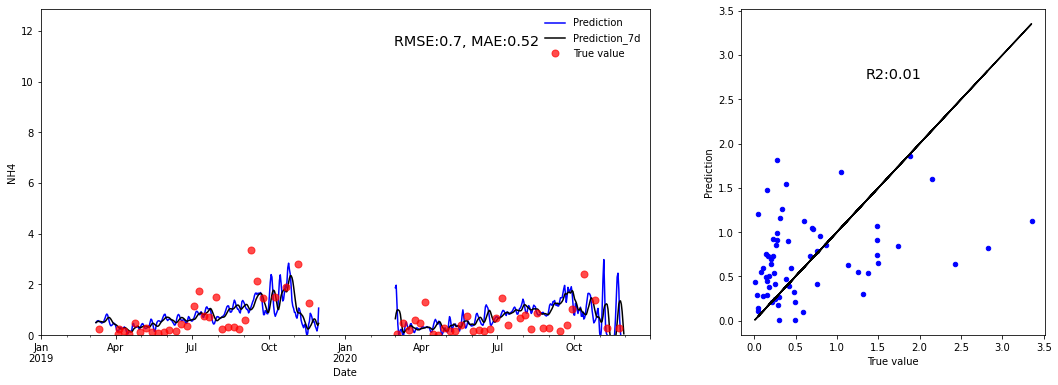

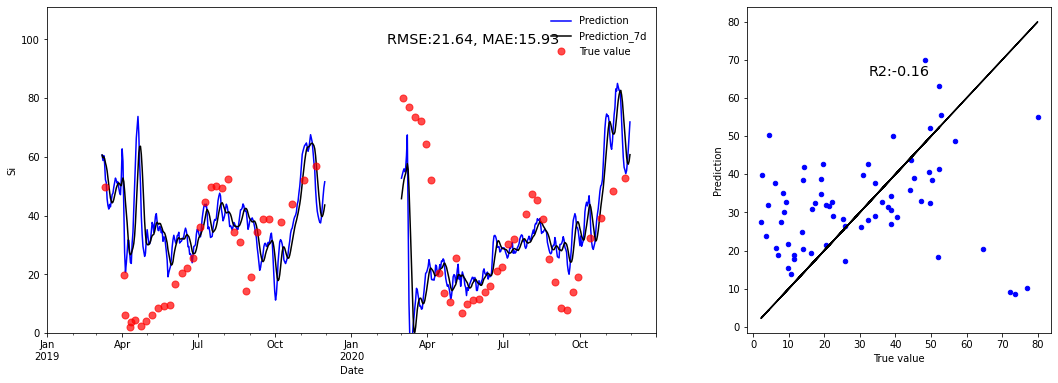

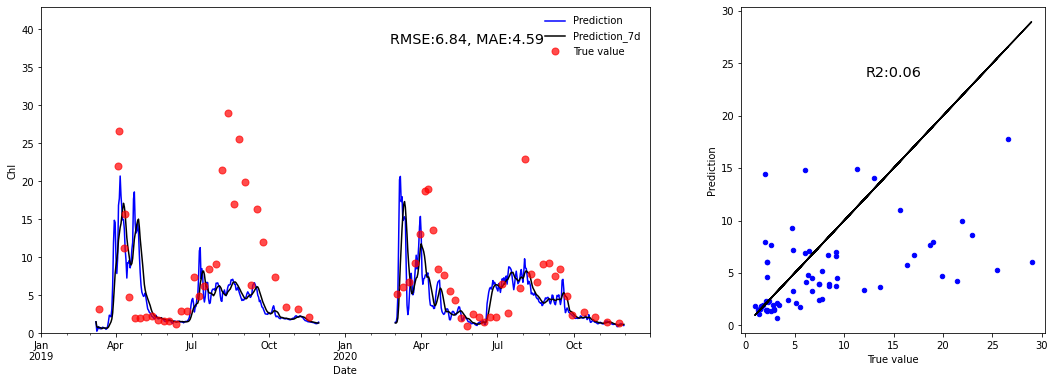

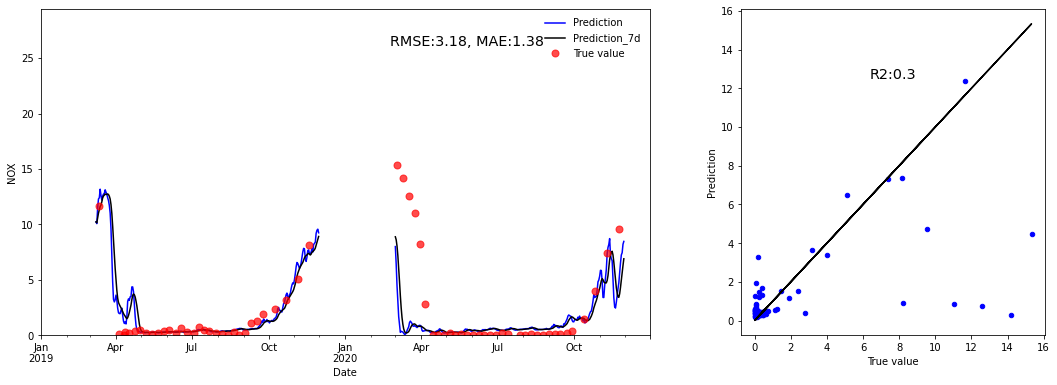

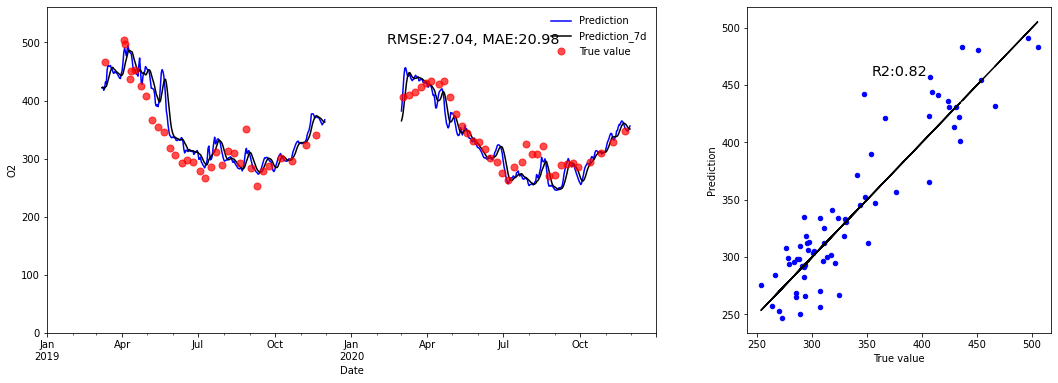

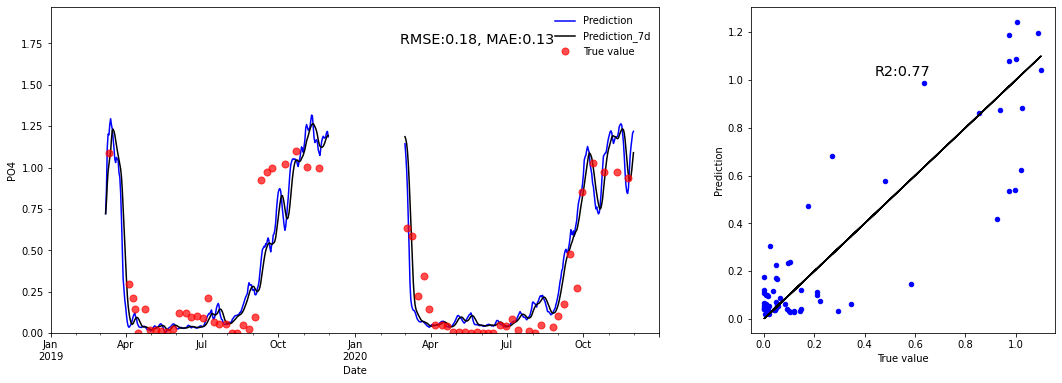

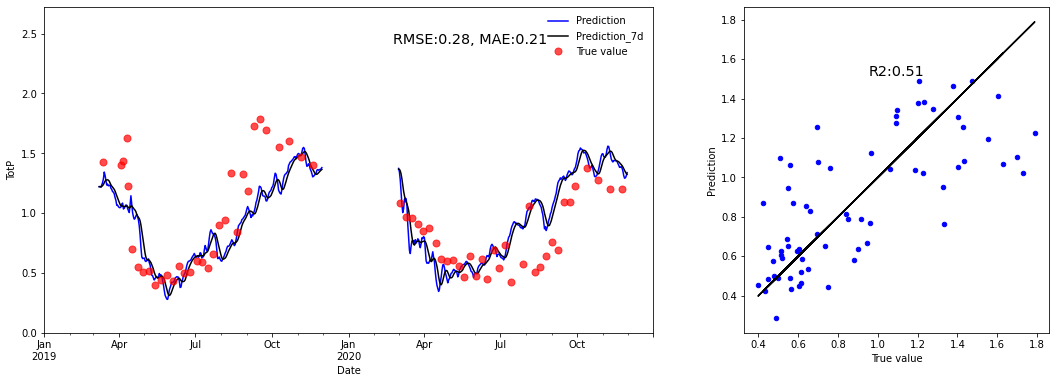

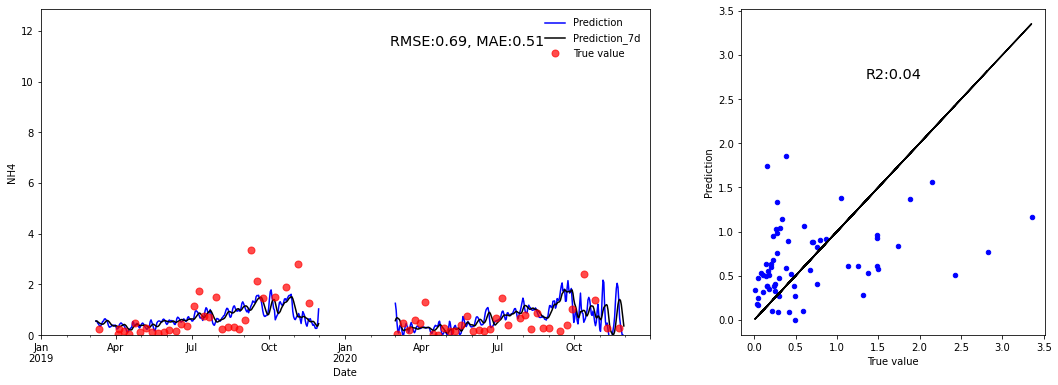

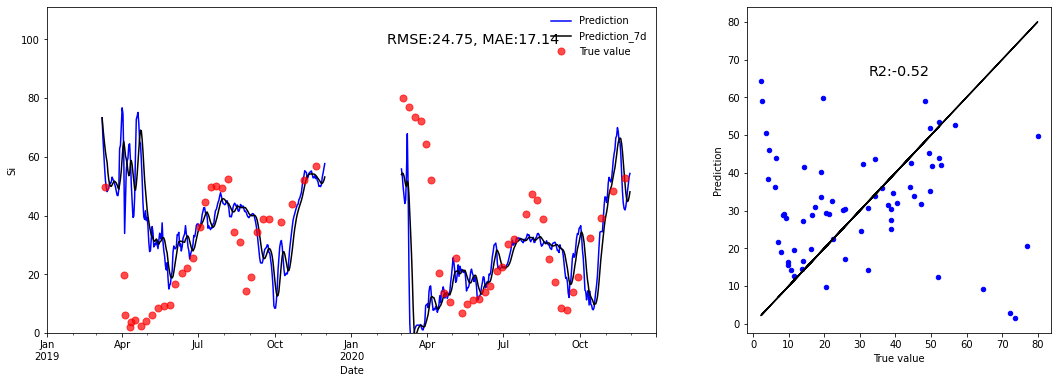

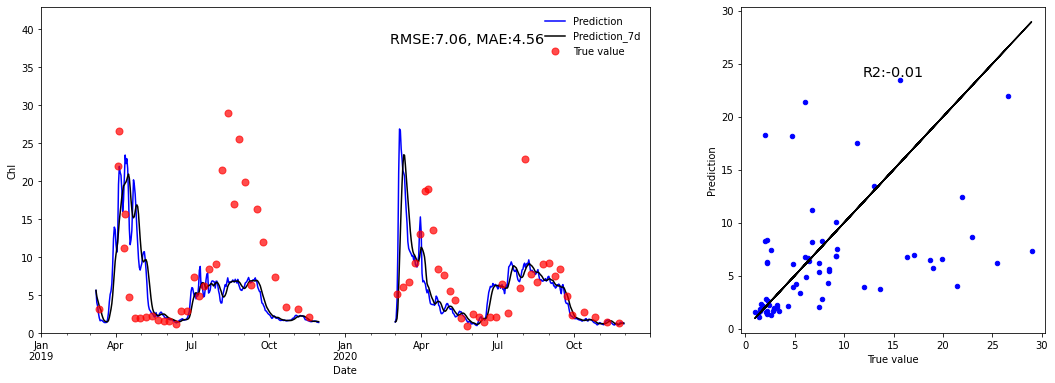

In [8]:
# Define the features and years
## Specify the training year (take 13 years from 2004-2018)
for i in range(15,20):
    year = all_df['Date'].apply(lambda d:d.year).unique()
    #print('Dataset contains years:{},in total {} years'.format(year,len(year)))
    Dataset_range= [pd.Timestamp(year[5],1,1),
                    pd.Timestamp(year[21],12,31)]

    year = year[5:20]
    random.shuffle(year)
    training_yr=year[0:13]
    training_yr.sort()
    ids=map(id,list(training_yr_df.values()))
    if id(training_yr) not in ids:
        training_yr_df[i]=training_yr
        start_time = time.time()
        os.chdir(Observation)
        # Load daily physical factors
        features = ['Date','delT', 'U', 'CC', 'SWR', 'Humidity', 'Prec', 'inflow', 'outflow', 'Ice_d', 
            'days from iceoff', 'thermD', 'MLD', 'W', 'AirT']
        file = lakename+'_Daily_Observation_df_nowinter.csv'
        Daily_df = read_daily_df(features,file) 
        Daily_df = Daily_df[Daily_df['Date']>Dataset_range[0]]
        os.chdir(LSTM_save_folder)
        features.pop(0) # Pop 'Date'
        Scaler_X = MinMaxScaler()
        Scaler_y = MinMaxScaler()#PowerTransformer(standardize=False)
        start_time = time.time()
        for j in range(n_Nut):#n_Nut
            nutrient=Nut_f[j+1]
            if j==0:
                Nut_memory = Daily_df.merge(pd.concat([Nut_df['Date'],
                                                       Nut_df[nutrient]],
                                                      axis = 1).dropna().drop_duplicates('Date'),
                                            how = 'left',on = 'Date')
            else: 
                Nut_memory = Nut_memory.merge(pd.concat([Nut_df['Date'],
                                                       Nut_df[nutrient]],
                                                      axis = 1).dropna().drop_duplicates('Date'),
                                            how = 'left',on = 'Date')

            print(nutrient)
            features.append(nutrient)
            values = load_dataset(Nut_memory,features)
            # frame as supervised learning
            reframed = reframe(values,hyperparameters,features)
            reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),
                                         columns=reframed.columns[:-1])
            #target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
            #                 name=reframed.columns[-1])
            target_array=pd.Series(reframed.iloc[:,-1].values.reshape(-1, 1).reshape(-1),
                         name=reframed.columns[-1])

            reframed_scaled=pd.concat([reframed_scaled,target_array],axis=1)
            values = reframed_scaled.values
            ylim = (0,all_df[nutrient].max())
            start_time = time.time()
            Nut_model,rmse,mae,r2,figure,pred_ts = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
            # 5-fold cross validation was used to estimate the model performance
            print('Test RMSE: %.2f' % rmse)
            print('Test MAE: %.2f' % mae)
            print('Test R2: %.2f' %r2)
            Lake_Nut_metrics[nutrient]['MAE']=mae
            Lake_Nut_metrics[nutrient]['RMSE']=rmse
            Lake_Nut_metrics[nutrient]['R2']=r2
            print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
            figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)    
            print('\n')
            Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
        print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
        Nut_memory.to_csv(lakename+'_LSTM predicted nutrient and Chl data_'+str(i)+'.csv',sep='\t',index = False)
        Lake_Nut_metrics.to_csv(lakename+'_LSTM_metrics_'+str(i)+'.csv',index=False)
    else:
        break

In [223]:
Lake_Nut_metrics

,NOX,O2,PO4,TotP,NH4,Si,Chl
MAE,1.39949,26.452821,0.130226,0.204109,0.455116,16.064404,4.417858
RMSE,3.005336,35.135064,0.172186,0.274558,0.614602,20.07202,6.98548
R2,0.375029,0.688444,0.791477,0.517711,0.2418,-0.001397,0.014562


# GBR

In [14]:
# Load testing dataset(Daily data)
def read_daily_test_df(test_time,features,file): # test_time = pd.Timestamp(yyyy,mm,dd)
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[features]
    #Lake_HydMet = Lake_HydMet[(Lake_HydMet['Date']>=test_time[0])&(Lake_HydMet['Date']<=test_time[1])].dropna()
    return Lake_HydMet

def training_cv(df,features,nutrient,year,loss_func):
    df['YY'] = df['Date'].apply(lambda d:d.year)
    features.append(nutrient)
    df = df[df['YY'].isin(year)][features].dropna()
    X_train = df.iloc[:,:-1]
    y_train = df.iloc[:,-1].values
    print('Number of samples: ' + str(len(y_train)))

    GBR = GradientBoostingRegressor(random_state=101)
    n_estimators = [int(x) for x in np.arange(40,140,20)]
    max_depth=[int(x) for x in np.arange(5,10,1)]
    learning_rate = [x for x in [0.01,0.1,1]]
    subsample = [x for x in [0.7,0.8,0.9,1]]
    param_grid = {'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'learning_rate':learning_rate,
                  'subsample':subsample}
    GBR_rs = RandomizedSearchCV(estimator = GBR,param_distributions = param_grid,n_iter = 30,cv = 5,verbose = 0)
    GBR_rs.fit(X_train,y_train)
    GBR.set_params(**GBR_rs.best_params_,random_state=101,loss=loss_func).fit(X_train,y_train)
    mae= -cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'neg_mean_absolute_error')
    rmse = np.sqrt(-cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error'))
    r2 = cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'r2')
    print('Training dataset evaluation:')
    print("MAE %.2f (+/- %.2f)" % (mae.mean(), mae.std()))
    print("RMSE %.2f (+/- %.2f)" % (rmse.mean(), rmse.std()))
    print("R2 %.2f (+/- %0.2f)" % (r2.mean(), r2.std()))
    pickle.dump(GBR, open("GBR."+nutrient.split('(')[0]+".dat", "wb"))
    features.pop()    

def predict(Erken_Nut,df,features,nutrient,test_time,ylim,Lake_Nut_metrics):
    #load the target GBR model
    GBR = pickle.load(open("GBR."+nutrient.split('(')[0]+".dat", "rb"))
    #predict yhat using test_X
    Erken_Nut[nutrient]=GBR.predict(Erken_Nut[features])
    nutrient_compare = Erken_Nut[['Date',nutrient]].merge(df[['Date',nutrient]].dropna(),
                                                          how = 'inner',on = 'Date')
    nutrient_compare.columns = ['Date','Prediction','True']
    Date = pd.DataFrame(pd.date_range(start = test_time[0],
                                      end = test_time[1]),
                    columns = ['Date'])
    #Erken_Nut_gap = Date.merge(Erken_Nut,how = 'left',on = 'Date')
    nutrient_compare=nutrient_compare[(nutrient_compare['Date']>=test_time[0])&(nutrient_compare['Date']<=test_time[1])]
    Lake_Nut_metrics[nutrient]['MAE']=mean_absolute_error(nutrient_compare['True'],
                                                          nutrient_compare['Prediction'])
    Lake_Nut_metrics[nutrient]['RMSE']=mean_squared_error(nutrient_compare['True'],
                                                          nutrient_compare['Prediction'],
                                                          squared = False)    
    Lake_Nut_metrics[nutrient]['R2']=r2_score(nutrient_compare['True'],
                                              nutrient_compare['Prediction'])
    return Erken_Nut[['Date',nutrient]],Lake_Nut_metrics

In [15]:
training_yr_df={}
test_time = [pd.Timestamp(2019,1,1),pd.Timestamp(2020,12,31)]
test_yr=list(range(test_time[0].year,test_time[1].year+1))
# 14 daily physical factors
n_feature = 14
# Create the daily df with Nan in nutrients columns
n_Nut = 7
Nut_f = ['NOX', 'O2', 'PO4', 'TotP', 'NH4', 'Si', 'Chl']
Lake_Nut_metrics = pd.DataFrame(columns = Nut_f,index=['MAE','RMSE','R2'])
Lake_Nut=pd.DataFrame(columns = ['Date'])

In [56]:
for i in range(30):
    year = all_df['Date'].apply(lambda d:d.year).unique()
    #print('Dataset contains years:{},in total {} years'.format(year,len(year)))
    Dataset_range= [pd.Timestamp(year[5],1,1),
                    pd.Timestamp(year[21],12,31)]

    year = year[5:20]
    random.shuffle(year)
    training_yr=year[0:13]
    training_yr.sort()
    ids=map(id,list(training_yr_df.values()))
    if id(training_yr) not in ids:
        training_yr_df[i]=training_yr
        start_time = time.time()
        os.chdir(Observation)
        # Load daily physical factors
        features = ['Date','delT', 'U', 'CC', 'SWR', 'Humidity', 'Prec', 'inflow', 'outflow', 'Ice_d', 
            'days from iceoff', 'thermD', 'MLD', 'W', 'AirT']
        file = lakename+'_Daily_Observation_df_nowinter.csv'
        testing_daily_df = read_daily_test_df(test_time,features,file) 
        os.chdir(GBR_save_folder)

        loss_func='huber'
        features.pop(0)
        start_time = time.time()
        for j in range(n_Nut): 
            if j!=0:
                features.append(Nut_f[j-1]) 
            nutrient=Nut_f[j]
            print(nutrient)    
            if j==0:
                model = training_cv(all_df,features,nutrient,training_yr,loss_func)
            else:
                model = training_cv(testing_daily_df.merge(all_df[['Date']+[nutrient]],on='Date',how='outer')
                                    ,features,nutrient,training_yr,loss_func)
            ylim = (0,all_df[Nut_f[j]].max())
            Model,Lake_Nut_metrics = predict(testing_daily_df,all_df,
                                                  features,nutrient,test_time,
                                                  ylim,Lake_Nut_metrics)
            Lake_Nut =Lake_Nut.merge(Model,on=['Date'],how='outer')
            print('\n')

        print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
        Lake_Nut.to_csv(lakename+'_GBR predicted nutrient and Chl_'+str(i)+'.csv',index = False)
        Lake_Nut_metrics.to_csv(lakename+'_GBR_metrics_'+str(i)+'.csv',index=False)
        Lake_Nut=pd.DataFrame(columns = ['Date'])
    else:
        break

NOX
Number of samples: 423
Training dataset evaluation:
MAE 1.57 (+/- 0.38)
RMSE 2.70 (+/- 0.52)
R2 0.42 (+/- 0.12)


O2
Number of samples: 683
Training dataset evaluation:
MAE 20.17 (+/- 4.62)
RMSE 27.10 (+/- 6.44)
R2 0.74 (+/- 0.07)


PO4
Number of samples: 432
Training dataset evaluation:
MAE 0.19 (+/- 0.02)
RMSE 0.28 (+/- 0.03)
R2 0.49 (+/- 0.28)


TotP
Number of samples: 433
Training dataset evaluation:
MAE 0.16 (+/- 0.03)
RMSE 0.21 (+/- 0.03)
R2 0.70 (+/- 0.09)


NH4
Number of samples: 426
Training dataset evaluation:
MAE 0.52 (+/- 0.09)
RMSE 0.77 (+/- 0.27)
R2 0.21 (+/- 0.11)


Si
Number of samples: 423
Training dataset evaluation:
MAE 19.10 (+/- 3.31)
RMSE 22.89 (+/- 4.18)
R2 -0.28 (+/- 0.34)


Chl
Number of samples: 453
Training dataset evaluation:
MAE 2.58 (+/- 0.28)
RMSE 3.94 (+/- 0.63)
R2 0.59 (+/- 0.04)


Model takes 3 min to run
NOX
Number of samples: 419
Training dataset evaluation:
MAE 1.60 (+/- 0.21)
RMSE 2.93 (+/- 0.38)
R2 0.40 (+/- 0.15)


O2
Number of samples: 681
T

Training dataset evaluation:
MAE 0.54 (+/- 0.07)
RMSE 0.84 (+/- 0.23)
R2 0.18 (+/- 0.15)


Si
Number of samples: 422
Training dataset evaluation:
MAE 17.98 (+/- 3.03)
RMSE 21.98 (+/- 3.41)
R2 -0.60 (+/- 0.65)


Chl
Number of samples: 459
Training dataset evaluation:
MAE 2.84 (+/- 0.34)
RMSE 4.36 (+/- 0.64)
R2 0.43 (+/- 0.15)


Model takes 3 min to run
NOX
Number of samples: 421
Training dataset evaluation:
MAE 1.66 (+/- 0.19)
RMSE 3.03 (+/- 0.33)
R2 0.38 (+/- 0.11)


O2
Number of samples: 683
Training dataset evaluation:
MAE 21.55 (+/- 6.27)
RMSE 28.49 (+/- 8.69)
R2 0.72 (+/- 0.12)


PO4
Number of samples: 427
Training dataset evaluation:
MAE 0.17 (+/- 0.03)
RMSE 0.25 (+/- 0.04)
R2 0.61 (+/- 0.09)


TotP
Number of samples: 428
Training dataset evaluation:
MAE 0.17 (+/- 0.01)
RMSE 0.23 (+/- 0.02)
R2 0.66 (+/- 0.12)


NH4
Number of samples: 423
Training dataset evaluation:
MAE 0.48 (+/- 0.05)
RMSE 0.72 (+/- 0.17)
R2 0.22 (+/- 0.16)


Si
Number of samples: 418
Training dataset evaluation:

Training dataset evaluation:
MAE 21.95 (+/- 6.56)
RMSE 29.20 (+/- 8.87)
R2 0.69 (+/- 0.17)


PO4
Number of samples: 437
Training dataset evaluation:
MAE 0.17 (+/- 0.01)
RMSE 0.25 (+/- 0.02)
R2 0.56 (+/- 0.20)


TotP
Number of samples: 432
Training dataset evaluation:
MAE 0.16 (+/- 0.02)
RMSE 0.21 (+/- 0.02)
R2 0.68 (+/- 0.16)


NH4
Number of samples: 429
Training dataset evaluation:
MAE 0.52 (+/- 0.10)
RMSE 0.80 (+/- 0.28)
R2 0.22 (+/- 0.14)


Si
Number of samples: 422
Training dataset evaluation:
MAE 18.64 (+/- 4.18)
RMSE 22.16 (+/- 3.83)
R2 -0.14 (+/- 0.29)


Chl
Number of samples: 464
Training dataset evaluation:
MAE 2.68 (+/- 0.42)
RMSE 4.05 (+/- 0.86)
R2 0.56 (+/- 0.08)


Model takes 3 min to run
NOX
Number of samples: 421
Training dataset evaluation:
MAE 1.45 (+/- 0.28)
RMSE 2.77 (+/- 0.50)
R2 0.42 (+/- 0.14)


O2
Number of samples: 557
Training dataset evaluation:
MAE 23.01 (+/- 6.80)
RMSE 31.46 (+/- 10.12)
R2 0.64 (+/- 0.15)


PO4
Number of samples: 424
Training dataset evaluat

Training dataset evaluation:
MAE 2.70 (+/- 0.39)
RMSE 4.15 (+/- 0.75)
R2 0.48 (+/- 0.17)


Model takes 4 min to run
NOX
Number of samples: 422
Training dataset evaluation:
MAE 1.57 (+/- 0.36)
RMSE 2.67 (+/- 0.51)
R2 0.39 (+/- 0.25)


O2
Number of samples: 688
Training dataset evaluation:
MAE 20.22 (+/- 5.32)
RMSE 27.83 (+/- 8.21)
R2 0.73 (+/- 0.11)


PO4
Number of samples: 431
Training dataset evaluation:
MAE 0.16 (+/- 0.03)
RMSE 0.23 (+/- 0.04)
R2 0.66 (+/- 0.11)


TotP
Number of samples: 431
Training dataset evaluation:
MAE 0.16 (+/- 0.02)
RMSE 0.21 (+/- 0.02)
R2 0.71 (+/- 0.08)


NH4
Number of samples: 425
Training dataset evaluation:
MAE 0.52 (+/- 0.11)
RMSE 0.75 (+/- 0.24)
R2 0.22 (+/- 0.17)


Si
Number of samples: 421
Training dataset evaluation:
MAE 20.02 (+/- 4.11)
RMSE 23.75 (+/- 4.41)
R2 -0.46 (+/- 0.62)


Chl
Number of samples: 454
Training dataset evaluation:
MAE 2.57 (+/- 0.27)
RMSE 3.96 (+/- 0.66)
R2 0.57 (+/- 0.05)


Model takes 3 min to run
